In [2]:
import sys 
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import numpy as np
import pandas as pd
from scipy.stats import zscore

In [3]:
eigcent = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_eigcent.csv')
disp = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_dispersion.csv')

z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')
z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]
z_data = z_data.dropna()

z_data['br_z_ave'] = z_data['z_ave']
z_data.drop('z_ave', axis=1, inplace=True)
z_data['b_z_ave'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']))/3
z_data['brd_z_ave'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']) + zscore(z_data['RRS_reflection']) + zscore(z_data['RRS_depression']))/5

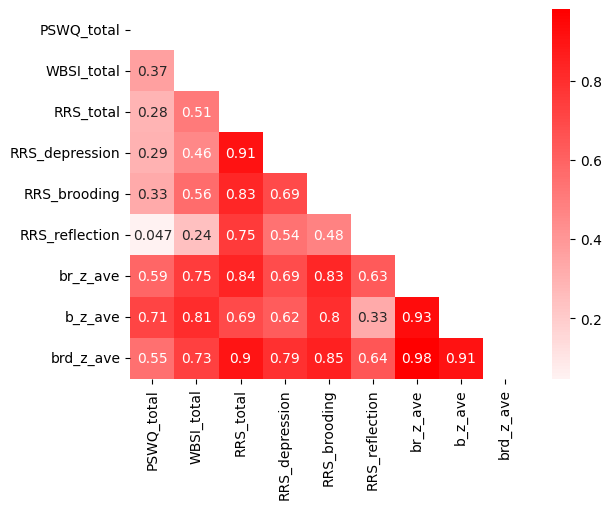

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Calculate the correlation matrix using Spearman method
correlation_matrix = z_data.filter(regex='RRS|total|ave').corr(method='spearman')

# Perform clustering on rows and columns separately
row_linkage = hierarchy.linkage(hierarchy.distance.pdist(correlation_matrix), method='average')
col_linkage = hierarchy.linkage(hierarchy.distance.pdist(correlation_matrix.T), method='average')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate a clustermap only showing the lower half
cluster_map = sns.heatmap(
    correlation_matrix,
    mask=mask,  # Apply the mask to hide the upper triangle
    center=0,
    cmap='bwr',
    annot=True,
    #row_linkage=row_linkage,
    #col_linkage=col_linkage,
    #dendrogram_ratio=(0.05, 0.05),  # Minimizing dendrogram visuals
    #tree_kws={'linewidths': 0}
    # Uncomment below if you need to adjust the color bar position
    #cbar_pos=(0.8, 0.065, 0.05, 0.2)  # Bottom right color bar position
)

plt.show()


In [5]:
sub_data = pd.merge(z_data, eigcent, on='SubID')
sub_data = pd.merge(sub_data, disp, on='SubID')

In [6]:
import seaborn as sns
import pandas as pd
from scipy.cluster import hierarchy

# Calculate the correlation matrix
correlation_matrix = sub_data.filter(regex='cent|disp').corr(method='spearman')

# Perform clustering on rows and columns separately
row_linkage = hierarchy.linkage(correlation_matrix, method='average')
col_linkage = hierarchy.linkage(correlation_matrix.T, method='average')

#sns.clustermap(
#    correlation_matrix,
#    center=0,
#    cmap='bwr',
#    dendrogram_ratio=(0.05, 0.05),  # Minimizing dendrogram visuals
#    tree_kws={'linewidths': 0},  # Thinner dendrogram lines
#    cbar_pos=(0.8, 0.065, 0.05, 0.2)  # Bottom right color bar position (x, y, width, height)
#)


In [7]:
#sns.clustermap(pd.merge(eigcent, disp, on='SubID').iloc[:, 1:10].corr(), center=0, cmap='bwr', annot=True)

In [23]:
#data, target, networks, color, like=None, remove=None, save=None):

data = sub_data
target = ['brd_z_ave']
networks = ['vn', 'smn', 'fpcn', 'dmn']
like = ['dispersion_md']


import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

# Create an instance of LeaveOneOut
loo = LeaveOneOut()
scaler=MinMaxScaler()


X_data = data

# Extract the feature matrix X and target variable y   
regex_string = '|'.join(networks)
X = X_data.filter(regex=regex_string).dropna()

if like is not None:
    like_strings = '|'.join(like)
    X = X.filter(like=like_strings)

# fit and transform the entire dataframe
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = X_data[target].iloc[X.index, :]
#y = pd.DataFrame(scaler.fit_transform(y), columns=y.columns)


pls = PLSRegression(n_components=1)

# Fit the PLSRegression model to the feature matrix X and target variable y using the optimal number of components
pls.n_components = 1 #optimal_n_components
pls.fit(X, y)

# Compute the singular value of the fitted model
x_score = pls.x_scores_
y_score = pls.y_scores_
singular_value = np.dot(x_score.T, y_score)

n_permutations = 10000
# Generate permuted data matrices by randomly reordering the rows of the original data matrix X
permuted_singular_values = []
for i in range(n_permutations):
    permuted_X = X.sample(frac=1, replace=False)
    pls.fit(permuted_X, y)
    x_score = pls.x_scores_
    y_score = pls.y_scores_
    permuted_singular_value = np.dot(x_score.T, y_score)
    permuted_singular_values.append(permuted_singular_value)

# Compute the p-value of the singular value by comparing it to the null distribution of singular values
p_value = (np.sum(permuted_singular_values >= singular_value) + 1) / (n_permutations + 1)

# Mean and standard deviation of the permuted singular values
permuted_mean = np.mean(permuted_singular_values)
permuted_std = np.std(permuted_singular_values)

# Effect size
effect_size = (singular_value - permuted_mean) / permuted_std
effect_size[0][0]

2.4011253095074236

In [9]:
# Effect size
effect_size = (singular_value - permuted_mean) / permuted_std
effect_size[0][0]

2.35688145384419

In [10]:
p_value 

0.004899510048995101

In [ ]:
boot_vip_pls(data, target, networks, like=None, remove=None, save=None)

In [25]:
def pls(data, target, networks, color, like=None, remove=None, save=None):
    
    import seaborn as sns
    from sklearn.cross_decomposition import PLSRegression
    from scipy.stats import t
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import StandardScaler
    
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import LeaveOneOut
    
    # Create an instance of LeaveOneOut
    loo = LeaveOneOut()
    scaler=MinMaxScaler()
    
    
    X_data = data
    
    # Extract the feature matrix X and target variable y   
    regex_string = '|'.join(networks)
    X = X_data.filter(regex=regex_string).dropna()
    
    if like is not None:
        like_strings = '|'.join(like)
        X = X.filter(like=like_strings)
        
    if remove is not None:
        remove_strings = '|'.join(remove)
        X = X.filter(regex=f'^(?!.*({remove_strings})).*$')

    # fit and transform the entire dataframe
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y = X_data[target].iloc[X.index, :]
    y = pd.DataFrame(scaler.fit_transform(y), columns=y.columns)

    # Set the number of permutations and bootstrap repetitions
    n_permutations = 10000
    n_bootstrap = 10000

    pls = PLSRegression(n_components=1)
    
    # Perform leave-one-out cross-validation to determine the optimal number of components
    #mse_values = []
    #for n_components in range(1, len(X.columns)+1):
    #    pls.n_components = n_components
    #    y_pred = cross_val_predict(pls, X, y, cv=loo)
    #    mse = mean_squared_error(y, y_pred)
    #    mse_values.append(mse)

    #pls = PLSRegression(n_components=1)
    #optimal_n_components = np.argmin(mse_values) + 1
    #print('LOCV Optimal number of components:', optimal_n_components)

    # Fit the PLSRegression model to the feature matrix X and target variable y using the optimal number of components
    pls.n_components = 1 #optimal_n_components
    pls.fit(X, y)

    # Compute the singular value of the fitted model
    x_score = pls.x_scores_
    y_score = pls.y_scores_
    singular_value = np.dot(x_score.T, y_score)

    # Generate permuted data matrices by randomly reordering the rows of the original data matrix X
    permuted_singular_values = []
    for i in range(n_permutations):
        permuted_X = X.sample(frac=1, replace=False)
        pls.fit(permuted_X, y)
        x_score = pls.x_scores_
        y_score = pls.y_scores_
        permuted_singular_value = np.dot(x_score.T, y_score)
        permuted_singular_values.append(permuted_singular_value)

    # Compute the p-value of the singular value by comparing it to the null distribution of singular values
    p_value = (np.sum(permuted_singular_values >= singular_value) + 1) / (n_permutations + 1)
    
    # Mean and standard deviation of the permuted singular values
    permuted_mean = np.mean(permuted_singular_values)
    permuted_std = np.std(permuted_singular_values)
    # Effect size
    effect_size = (singular_value - permuted_mean) / permuted_std

    import seaborn as sns
    from sklearn.cross_decomposition import PLSRegression
    from scipy.stats import t
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    import matplotlib

    # Prepare data for the histogram
    singular_list = [i[0][0] for i in permuted_singular_values]
    singulars = pd.DataFrame(singular_list, columns=['Singulars'])
    singular_val = singular_value[0][0]

    # Begin plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Set up a figure with two subplots
    
    # Scatter plot on the left
    sns.set_theme(style="white")

    sns.regplot(x=x_score.flatten(), y=y_score.flatten(), 
                ax=axs[0], color=color, scatter_kws={'alpha':0.6}, truncate=False)
    axs[0].set_xlabel('Network Dispersion (Latent Variable)', fontsize=14)
    axs[0].set_ylabel('Behavior (Latent Variable)', fontsize=14)
    axs[0].set_title('Network Dispersion Predicting Behavior', fontsize=14, fontweight='bold')
    
       # Displaying 'permuted P = ' with manual positioning for readability
    axs[0].text(.06, 1, 'permuted ', transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black')
    axs[0].text(.22, 1, 'P', transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black', fontstyle='italic')
    axs[0].text(.24, 1, ' = {:.3f}'.format(p_value), transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black')
    
    sns.despine(ax=axs[0])

    # Histogram on the right
    sns.histplot(singulars, kde=False, ax=axs[1])
    axs[1].axvline(x=singular_val, color='r', linestyle='--', label='Singular Value')
    axs[1].legend()
    axs[1].set_title("Singular Value vs. Null Distribution", fontsize=14, fontweight='bold')
    axs[1].set_xlabel('Permuted Singular Values (Null)', fontsize=14)
    sns.despine(ax=axs[1])
    plt.tight_layout()  # Adjust layout to not overlap
    
    if save is not None:
        save_path = f"/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/pls_plots/derosa_task_rsa_{save}.png"
        plt.savefig(save_path, dpi=700)
        
    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()
    
    return p_value


In [26]:
def boot_vip_pls(data, target, networks, like=None, remove=None, save=None):

    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.cross_decomposition import PLSRegression
    from sklearn.preprocessing import MinMaxScaler

    def calculate_vip_scores(pls_model, X):
        t = pls_model.x_scores_  # Scores
        w = pls_model.x_weights_  # Weights
        p = pls_model.x_loadings_  # Loadings
        q = pls_model.y_loadings_  # Y loadings

        # Calculate sum of squares of scores for each component
        t_ss = np.sum(t ** 2, axis=0)

        # Calculate weights squared times sum of squares of the x_scores
        w_ss = np.array([np.sum(w[:, i] ** 2 * t_ss[i]) for i in range(w.shape[1])])

        # Calculate VIP for each variable
        vip_sums = np.zeros(p.shape[0])
        for i in range(p.shape[1]):
            vip_sums += (p[:, i] ** 2) * w_ss[i] / t_ss[i]

        vip = np.sqrt(vip_sums * p.shape[1] / np.sum(t_ss))
        return vip
     

    # Extract the feature matrix X and target variable y   
    regex_string = '|'.join(networks)
    X_data = data.filter(regex=regex_string).dropna()
    
    if like is not None:
        like_strings = '|'.join(like)
        X_data = X_data.filter(like=like_strings)
        
    if remove is not None:
        remove_strings = '|'.join(remove)
        X_data = X_data.filter(regex=f'^(?!.*({remove_strings})).*$')


    # Preprocessing
    scaler = MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X_data), columns=X_data.columns)
    y = data[target].iloc[X.index, :]
    y = pd.DataFrame(scaler.fit_transform(y), columns=y.columns)

    # Fit initial PLS model to compute original loadings and VIP
    pls_initial = PLSRegression(n_components=1)
    pls_initial.fit(X, y)
    original_loadings = pls_initial.x_loadings_.flatten()
    original_vip = calculate_vip_scores(pls_initial, X)

    # Number of bootstrap iterations
    n_bootstraps = 10000
    bootstrapped_loadings = np.zeros((n_bootstraps, X.shape[1]))
    vip_scores_bootstrap = np.zeros((n_bootstraps, X.shape[1]))

    # Perform bootstrap for both metrics
    for i in range(n_bootstraps):
        sample_indices = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
        X_sample = X.iloc[sample_indices]
        y_sample = y.iloc[sample_indices]

        pls = PLSRegression(n_components=1)
        pls.fit(X_sample, y_sample)
        bootstrapped_loadings[i, :] = pls.x_loadings_.flatten()
        vip_scores_bootstrap[i, :] = calculate_vip_scores(pls, X_sample)

    # Organize bootstrapped data for plotting
    loadings_df = pd.DataFrame(bootstrapped_loadings, columns=X.columns).melt(var_name='variable', value_name='value').assign(kind='bootstrapped')
    vip_scores_df = pd.DataFrame(vip_scores_bootstrap, columns=X.columns).melt(var_name='variable', value_name='value').assign(kind='bootstrapped')

    # Prepare original data for plotting
    og_loadings = pd.DataFrame({'value': original_loadings, 'variable': X.columns}).assign(kind='original').sort_values('value', ascending=False)
    og_vip_scores = pd.DataFrame({'value': original_vip, 'variable': X.columns}).assign(kind='original').sort_values('value', ascending=False)

    # Concatenate bootstrapped and original data
    all_loadings = pd.concat([loadings_df, og_loadings])
    all_vip_scores = pd.concat([vip_scores_df, og_vip_scores])

    # Sort and organize features for plotting
    order_loadings = og_loadings['variable'].tolist()
    order_vip = og_vip_scores['variable'].tolist()

    all_loadings['variable'] = pd.Categorical(all_loadings['variable'], categories=order_loadings, ordered=True)
    all_loadings = all_loadings.sort_values('variable')
    all_vip_scores['variable'] = pd.Categorical(all_vip_scores['variable'], categories=order_vip, ordered=True)
    all_vip_scores = all_vip_scores.sort_values('variable')

    # Prepare plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 10))

    custom_palette = ['#3164AA', '#DF2E52']

    # Loadings plot
    sns.pointplot(data=all_loadings, y="variable", x="value", 
                  hue='kind', errorbar="sd", linestyles='', palette = custom_palette, 
                  join=False, markers=["o", "*"], ax=ax[0])

    ax[0].set_title('Bootstrapped and Original Loadings')
    ax[0].set_xlabel('Loadings Value')
    ax[0].set_ylabel('Features')

    # VIP scores plot
    sns.pointplot(data=all_vip_scores, y="variable", x="value", 
                  hue='kind', errorbar="sd", linestyles='', palette = custom_palette,
                  join=False, markers=["o", "*"], ax=ax[1])
    ax[1].set_title('Original and Bootstrapped VIP Scores')
    ax[1].set_xlabel('Variable Importance (VIP) Score')
    ax[1].set_ylabel('Features')

    # Position legends at the bottom of the figure
    ax[0].legend(title='Data Type', loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, shadow=False, ncol=2)
    ax[1].legend(title='Data Type', loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, shadow=False, ncol=2)

    plt.tight_layout()
    
    if save is not None:
        save_path = f"/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/pls_plots/{save}_bootstrapped_loadings_vip.png"
        plt.savefig(save_path)

    plt.show()

    loadings_and_vip = pd.concat([all_vip_scores.assign(analysis = 'vip'), all_loadings.assign(analysis = 'boot')])
    
    return loadings_and_vip

In [34]:
# Data Setup
networks = ['vn', 'smn', 'fpcn', 'dmn']
targets = [['brd_z_ave']]
colors = ['#64b3a3']
save_names = ['brd_z_ave']

sub_data = sub_data
data = sub_data

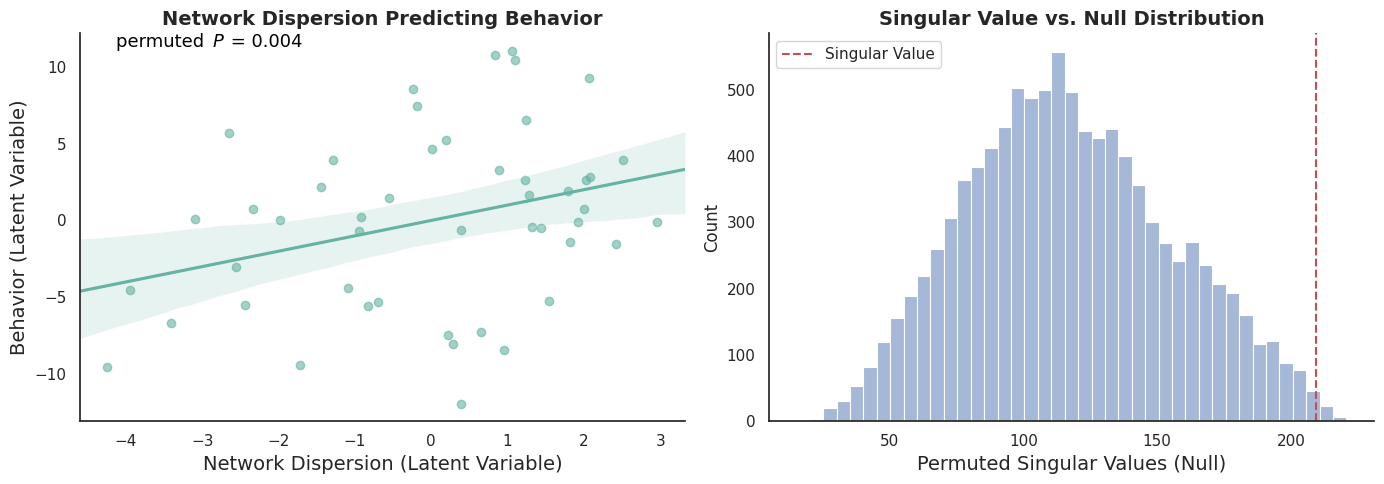

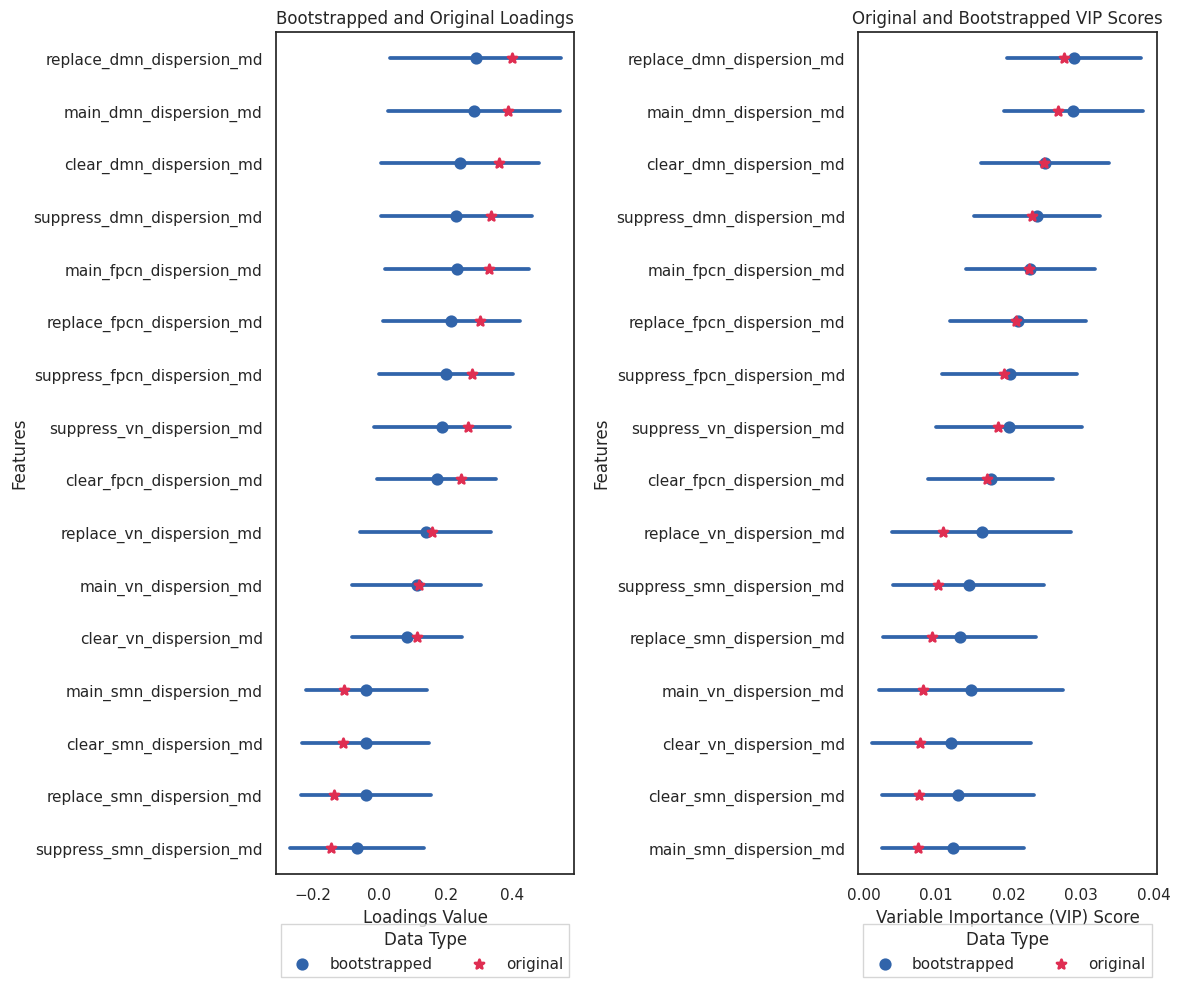

In [35]:
p_values=[]
loadings_and_vip_out = []
for i,j,k in zip(targets, colors, save_names):
    p_values.append(pls(data, i, networks, j, like=['dispersion_md'], save=k))
    loadings_and_vip_out.append(boot_vip_pls(data, i, networks, like=['dispersion_md'], save=k))

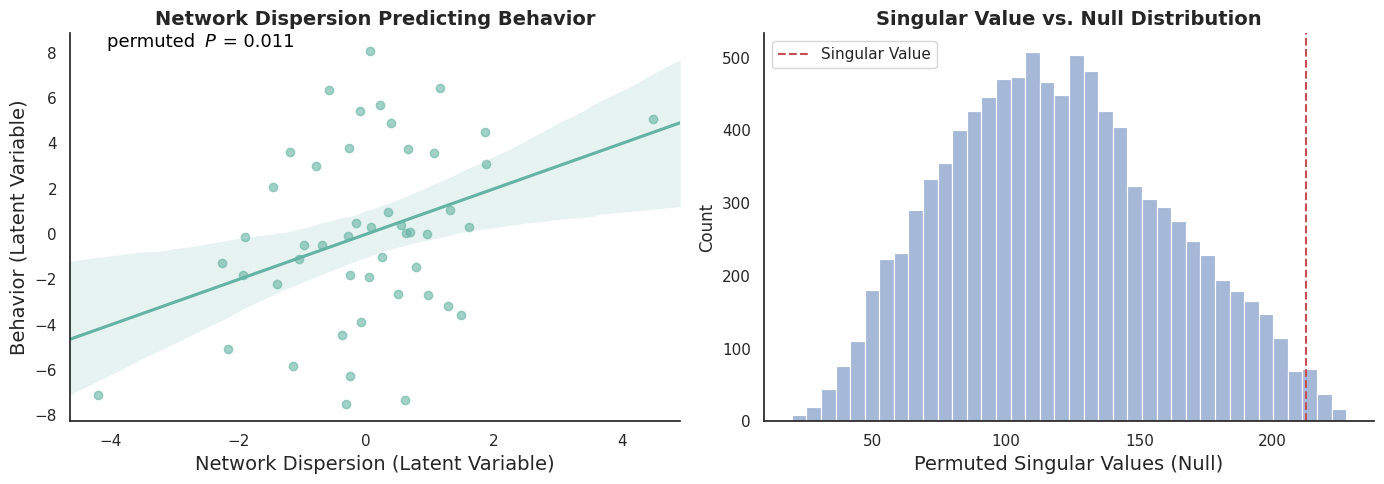

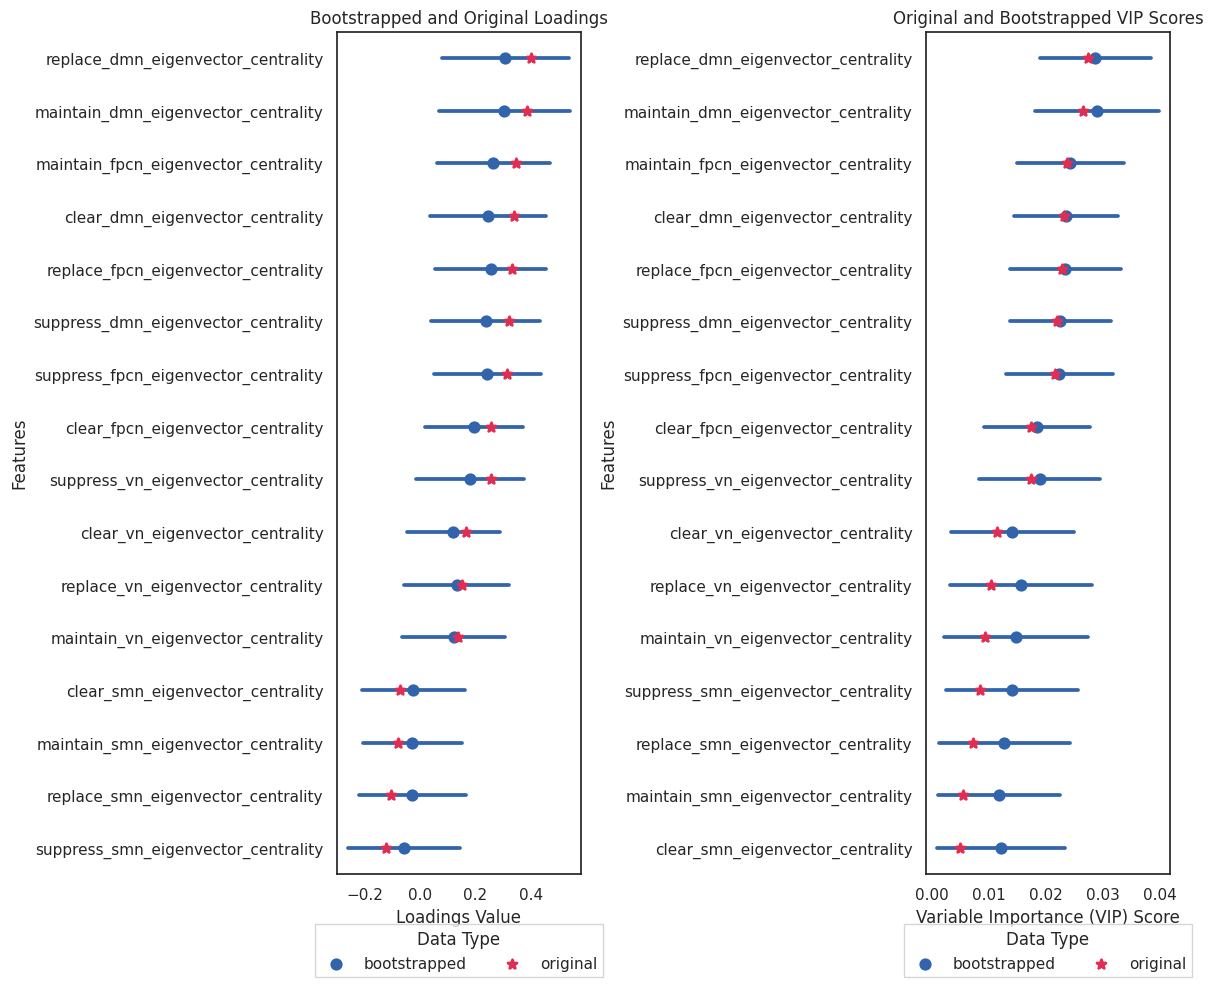

In [36]:
# Data Setup
networks = ['vn', 'smn', 'fpcn', 'dmn']
targets = [['brd_z_ave']]
colors = ['#64b3a3']

save_names = ['brd_z_ave_eig_cent']

sub_data = sub_data
data = sub_data

p_values=[]
loadings_and_vip_out = []
for i,j,k in zip(targets, colors, save_names):
    p_values.append(pls(data, i, networks, j, like=['eig'], save=k))
    loadings_and_vip_out.append(boot_vip_pls(data, i, networks, like=['eig'], save=k))